In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt 

from src.features import build_features

import logging 
from pathlib import Path

import scipy
import pickle
import datetime
import numpy as np

logging.basicConfig(level=logging.INFO)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\matan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\matan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.matutils import Sparse2Corpus
from gensim.corpora import Dictionary

from src.data.DBConnection import DBConnection
db = DBConnection()

# Build Features
Use the build_features functions to build dataset from database (usually takes ~1 min)

In [4]:
sql = "SELECT details FROM positions;"
query = db.cur.execute(sql)
documents = query.fetchall()

In [5]:
import re
import gensim
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from src.data.make_dataset import lematize

def process_documents(documents):
    # try new preprocessing steps:
    data = list(documents)
    # remove \n
    data = [text[0].replace("\n", " ") for text in data]
    # remove https:// links 
    data = [re.sub(r"((https{0,1}\:/\/\w{3}\S+)|(w{3}\S+))", "", text) for text in data]
    # remove emails:
    data = [re.sub(r"(\S+@\S+)", "", text) for text in data]
    # remove phone numbers:
    data = [re.sub(r"([\+\s01-]*\(*\d{3}\)*[-\s]\d{3}[-\s]\d{4})", "", text) for text in data]
    # remove uf0b7
    data = [re.sub(r"(\uf0b7)", "", text) for text in data]
    # remove handles:
    data = [re.sub(r"(\@\S+)", "", text) for text in data]
    # remove french documents
    data = [doc for doc in data if "une" not in doc and "connaissance" not in doc]
    return data

def docs_to_words(documents):
    for doc in documents:
        yield(gensim.utils.simple_preprocess(str(doc), deacc=True))  # deacc=True removes punctuations
        
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


stop_words = stopwords.words('english')
# remove super common words:
stop_words.extend(["data", "analytics", "team", "experience", "work", "business"])

clean_docs = process_documents(documents)
data_words = list(docs_to_words(clean_docs))

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Form trigrams:
data_words_trigrams = make_trigrams(data_words_bigrams)

# Lematize docs:
data_lemmatized = [lematize(words).split(" ") for words in data_words_trigrams]

INFO:gensim.models.phrases:collecting all words and their counts
INFO:gensim.models.phrases:PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO:gensim.models.phrases:collected 108915 word types from a corpus of 363120 words (unigram + bigrams) and 630 sentences
INFO:gensim.models.phrases:using 108915 counts as vocab in Phrases<0 vocab, min_count=5, threshold=100, max_vocab_size=40000000>
INFO:gensim.models.phrases:collecting all words and their counts
INFO:gensim.models.phrases:PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO:gensim.models.phrases:collected 110465 word types from a corpus of 351758 words (unigram + bigrams) and 630 sentences
INFO:gensim.models.phrases:using 110465 counts as vocab in Phrases<0 vocab, min_count=5, threshold=100, max_vocab_size=40000000>
INFO:gensim.models.phrases:source_vocab length 108915
INFO:gensim.models.phrases:Phraser built with 682 phrasegrams
INFO:gensim.models.phrases:source_vocab length 110465
INFO:gensim.models.p

In [7]:
# Create Dictionary
id2word = Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(8636 unique tokens: ['ability', 'accept', 'access', 'accuracy', 'actionable']...) from 630 documents (total 209192 corpus positions)


# PCA
To visualize the clustering algorithms I'll use two or three principal components throughout this notebook.

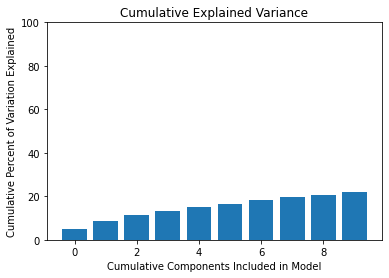

In [8]:
# initialize PCA:
# reduce features:
pca = PCA(n_components=10)
dense_corpus = gensim.matutils.corpus2dense(corpus, len(id2word.keys()))
reduced_features = pca.fit_transform(dense_corpus.T)

# display percent explained variance of the first ten components:
fig = plt.figure()
plt.bar(x=range(len(pca.explained_variance_ratio_)), height=np.cumsum(pca.explained_variance_ratio_)*100)
plt.ylim([0, 100])
plt.ylabel("Cumulative Percent of Variation Explained")
plt.xlabel("Cumulative Components Included in Model")
plt.title("Cumulative Explained Variance");

Unfortunately the first two components only seem to code for about 5% (if that) of the percent variation. This makes sense since the bog-of-words is massive, however this means that we cannot trust visual cluster, we'll need some empirical measure of clsuter goodness. 

In [9]:
import pandas as pd

loadings = pd.DataFrame(data=pca.components_, columns=id2word.values()).T

topics = pd.DataFrame()

for t in loadings.columns:
    topics[str(t)] = loadings[t].sort_values(ascending=False)[:10].index.tolist()
    
topics

,0,1,2,3,4,5,6,7,8,9
0,model,management,model,analysis,research,client,product,risk,agoda,agoda
1,learn,support,machine,analytical,client,solution,research,model,risk,customer
2,machine,report,solution,model,learn,product,agoda,use,solution,use
3,use,skill,skill,statistical,analysis,ibm,science,investment,learn,environment
4,customer,provide,develop,product,health,analysis,management,omers,opportunity,technology
5,build,project,learn,insight,ability,use,risk,build,development,marketing
6,solution,process,knowledge,skill,skill,agoda,include,game,machine,tool
7,help,client,service,stakeholder,project,drive,build,develop,climate,world
8,develop,analyst,research,customer,apply,market,partner,office,world,skill
9,technology,ability,technique,report,statistical,insight,analysis,insight,science,build


# SVD

In [10]:
from sklearn.decomposition import TruncatedSVD

svd_model = TruncatedSVD(n_components=6,         # num dimensions
                         algorithm='randomized',
                         n_iter=10)
svd_matrix = svd_model.fit_transform(dense_corpus.T)

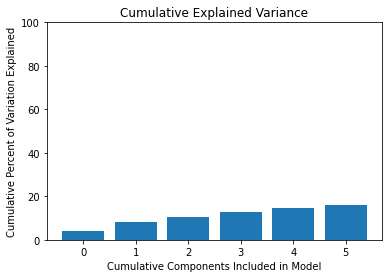

In [11]:
# display percent explained variance of the first ten components:
fig = plt.figure()
plt.bar(x=range(len(svd_model.explained_variance_ratio_)), height=np.cumsum(svd_model.explained_variance_ratio_)*100)
plt.ylim([0, 100])
plt.ylabel("Cumulative Percent of Variation Explained")
plt.xlabel("Cumulative Components Included in Model")
plt.title("Cumulative Explained Variance");

In [12]:
loadings = pd.DataFrame(data=svd_model.components_, columns=id2word.values()).T

topics = pd.DataFrame()

for t in loadings.columns:
    topics[str(t)] = loadings[t].sort_values(ascending=False)[:10].index.tolist()
    
topics

,0,1,2,3,4,5
0,technology,learn,model,analysis,research,client
1,learn,machine,machine,analytical,analysis,solution
2,model,model,solution,model,client,product
3,skill,science,skill,product,health,ibm
4,information,build,develop,statistical,ability,analysis
5,use,engineering,learn,insight,skill,agoda
6,product,ml,service,skill,learn,use
7,service,scientist,management,stakeholder,science,drive
8,science,ai,knowledge,customer,project,market
9,solution,product,client,report,statistical,insight


# LDA

In [13]:
logging.getLogger().setLevel(logging.CRITICAL)

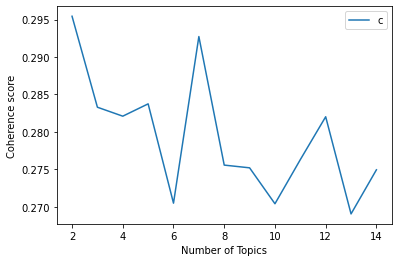

In [14]:
from gensim import corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# determine optimal number of topics using coherence score:
coherence_vals = []
model_list =[]
start = 2
stop = 15
step = 1

for num_topics in range(start, stop, step):
    # make LDa model and calc coherence:
    model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v', processes=1)
    coherence_vals.append(coherence_model.get_coherence())
    
x = range(start, stop, step)
plt.plot(x, coherence_vals)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

Not great results, but I guess there isn't that many different topics. Lets see the different topics.

In [15]:
best_model = model_list[coherence_vals.index(max(coherence_vals))]

best_model.print_topics()

[(0,
  '0.008*"technology" + 0.006*"information" + 0.006*"science" + 0.006*"industry" + 0.006*"skill" + 0.005*"job" + 0.005*"time" + 0.005*"learn" + 0.005*"model" + 0.005*"solution"'),
 (1,
  '0.007*"learn" + 0.007*"technology" + 0.007*"skill" + 0.006*"use" + 0.006*"product" + 0.006*"model" + 0.006*"information" + 0.005*"analysis" + 0.005*"service" + 0.005*"process"')]

In [16]:
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

In [19]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model_list[3], corpus, id2word)
vis

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.004010 -0.007090       1        1  36.142803
1      0.002421 -0.000110       2        1  23.867564
4     -0.007832 -0.002381       3        1  15.560660
0      0.006628  0.005072       4        1  12.698386
2     -0.005227  0.004510       5        1  11.730587, topic_info=         Term         Freq        Total Category  logprob  loglift
113     learn  1236.000000  1236.000000  Default  30.0000  30.0000
217       use  1045.000000  1045.000000  Default  29.0000  29.0000
165   product  1077.000000  1077.000000  Default  28.0000  28.0000
342   service  1028.000000  1028.000000  Default  27.0000  27.0000
251   company   738.000000   738.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
292   include    88.008140   791.634213   Topic5  -5.6306  -0.0537
183   science   101.577845  1069.334880   Topic5  -5.4872  -0.2110
638  customer    88.720544   854.797201   Topic5  -5.6225  -0.1224
109       job    91.866651  1023.503960   Topic5  -5.5877  -0.2677
496     build    88.464789   921.547212   Topic5  -5.6254  -0.2005

[448 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.387517  ability
0         2  0.294662  ability
0         3  0.097808  ability
0         4  0.123807  ability
0         5  0.096570  ability
...     ...       ...      ...
3496      1  0.193118    zynga
3496      2  0.193118    zynga
3496      3  0.193118    zynga
3496      4  0.193118    zynga
3496      5  0.289677    zynga

[1135 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 5, 1, 3])

In [20]:
dense_corpus.shape

c:\users\matan\github\linkedin-nlp\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(8636, 630)